In [1]:
pip install control

     |████████████████████████████████| 348kB 7.9MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=4150e40913a9a4158d89bc36c4624b5b0c91ff9cfc27b4f1d83622f674c0c2bc
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [2]:
pip install slycot

     |████████████████████████████████| 1.6MB 8.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417829 sha256=aac45ed4f5258ffa45bb705ae7ec28fd995edefd859037437faeb707dff00855
  Stored in directory: /root/.cache/pip/wheels/a2/46/56/f82cbb2fd06556f4f3952a2eb2396e8fd29264fffecbaad3cf
Successfully built slycot


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from control.matlab import *
import slycot
from scipy import signal
from scipy.linalg import fractional_matrix_power
# Python control toolbox available at https://python-control.readthedocs.io/

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})


In [4]:
A = np.array([[-0.75,1],[-0.3,-0.75]])
B = np.array([2,1]).reshape((2,1))
C = np.array([1,2])
D = 0

sys = ss(A,B,C,D)

Wc = gram(sys,'c') # Controllability Gramian
Wo = gram(sys,'o') # Observability Gramian

In [5]:
# Manually compute transform matrix for balanced Gramians
_,Tu = np.linalg.eig(Wc@Wo)

# Resolve sign ambiguity of eigenvectors
for j in range(Tu.shape[1]):
    if Tu[0,j] < 0:
        Tu[:,j] = -Tu[:,j]
        
Sig_c = np.linalg.inv(Tu) @ Wc @ np.linalg.inv(Tu).T
Sig_o = Tu.T @ Wo @ Tu
Sig_s = fractional_matrix_power(Sig_c,1/4) @ fractional_matrix_power(Sig_o,-1/4)

T = Tu @ Sig_s
Ti = np.linalg.inv(T)

In [6]:
An = Ti @ A @ T
Bn = Ti @ B
Cn = C @ T
Dn = 0

sysn = ss(An,Bn,Cn,Dn)

Wcn = gram(sysn,'c') # Controllability Gramian
Won = gram(sysn,'o') # Observability Gramian

In [7]:
## Plot Gramians
theta = np.arange(0,2*np.pi,0.01)
xc = np.cos(theta)
yc = np.sin(theta)
CIRC = np.row_stack((xc,yc))

# Off-diagonals should be within machine precision of 0, but
# in case that machine error is negative we manually threshold them:
Wcn[Wcn<0] = 0
Won[Won<0] = 0

ELLIPbc = Ti @ np.sqrt(Wcn) @ T @ CIRC
ELLIPbo = Ti @ np.sqrt(Won) @ T @ CIRC
ELLIPc = np.sqrt(Wc) @ CIRC
ELLIPo = np.sqrt(Wo) @ CIRC

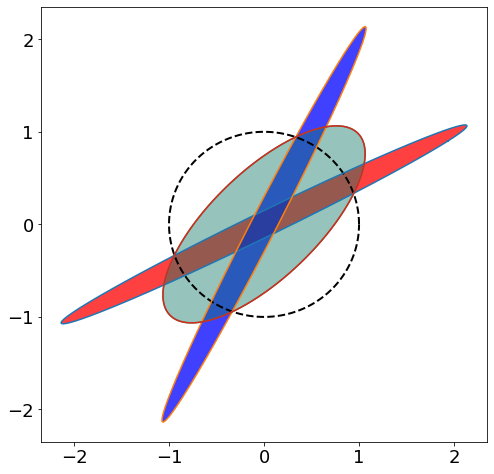

In [8]:
plt.plot(xc,yc,'k--',linewidth=2)

# Draw controllability Gramian (unbalanced)
plt.plot(ELLIPc[0].T,ELLIPc[1].T)
plt.fill(ELLIPc[0].T,ELLIPc[1].T,'r',alpha=0.75)

# Draw observability Gramian (unbalanced)
plt.plot(ELLIPo[0].T,ELLIPo[1].T)
plt.fill(ELLIPo[0].T,ELLIPo[1].T,'b',alpha=0.75)

# Draw balanced controllability Gramians
plt.plot(ELLIPbc[0].T,ELLIPbc[1].T)
plt.fill(ELLIPbc[0].T,ELLIPbc[1].T,'g',alpha=0.25)

# Draw balanced observability Gramians

plt.plot(ELLIPbo[0].T,ELLIPbo[1].T)
plt.fill(ELLIPbo[0].T,ELLIPbo[1].T,'o',alpha=0.25)
plt.show()